This notebook analyzes the final model. It explores the feaure importance and the precision of the model for different quantiles of the test set.

In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X_train_sc = pd.read_csv('data/X_train_sc.csv')
X_val_sc = pd.read_csv('data/X_val_sc.csv')
y_train_enc = np.ravel(pd.read_csv('data/y_train_enc.csv'))
y_val_enc = np.ravel(pd.read_csv('data/y_val_enc.csv'))


#make train and val customer id frames and drop from data
X_train_id = X_train_sc['customerid']
X_train_sc.drop('customerid',axis=1,inplace=True)
X_val_id = X_val_sc['customerid']
X_val_sc.drop('customerid',axis=1,inplace=True)


X_test_sc = pd.read_csv('data/X_test_sc.csv')
y_test_enc = pd.read_csv('data/y_test_enc.csv')

X_test_id = X_test_sc['customerid']
X_test_sc.drop('customerid',axis=1,inplace=True)

Load our final model and get the coefficient importance. They are plotted in the cell below.

In [13]:
best_lr = load('models/best_lr.joblib')
coefs = pd.DataFrame(abs(best_lr.coef_.T),columns=['Coefficient'],index=X_test_sc.columns).sort_values(by='Coefficient',ascending=False)[:10]
coefs.index = ['Contract','Phone Service','Tenure','Monthly Charges','Monthly/Total Charges','Total Charges/Tenure','Phone and Internet','Paperless Billing','Online Security','Senior Citizen']

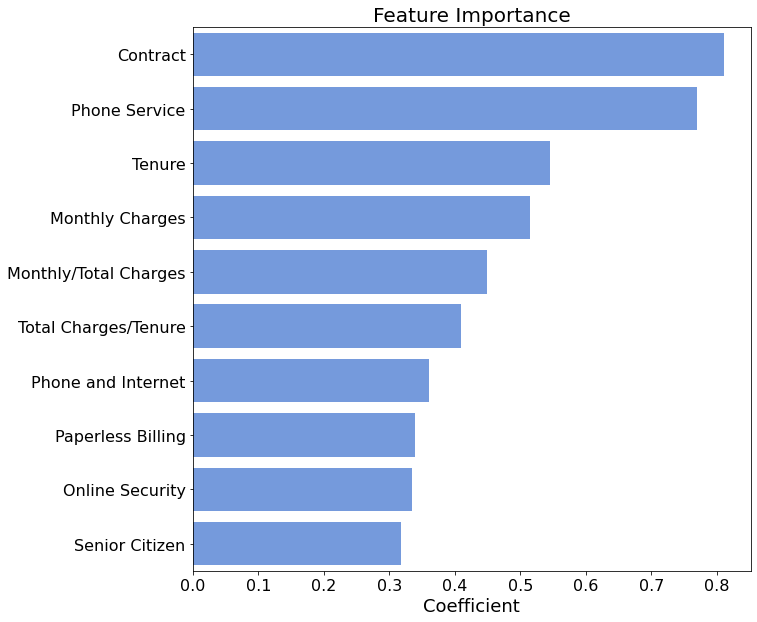

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x='Coefficient',y=coefs.index,data=coefs,ax=ax,color='cornflowerblue')
ax = plt.title('Feature Importance',fontsize=20)
ax = plt.yticks(fontsize=16)
ax = plt.xticks(fontsize=16)
ax = plt.xlabel('Coefficient', fontsize=18)


Next, get the probabilities of churn from the model and plot the distribution.

In [5]:
best_probs = pd.DataFrame(best_lr.predict_proba(X_test_sc))
best_probs = best_probs.join(X_test_id,how='left')

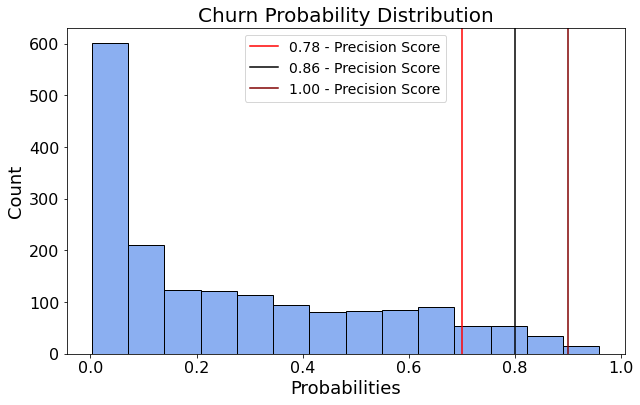

In [35]:
#look at distrobution
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,6))


sns.histplot(data=best_probs.iloc[:,1],color='cornflowerblue',ax=ax)
ax = plt.title('Churn Probability Distribution',fontsize=20)
ax = plt.xlabel('Probabilities',fontsize=18)
ax = plt.ylabel('Count',fontsize=18)
ax = plt.axvline(x=0.7,label='0.78 - Precision Score',color='red')
ax = plt.axvline(x=0.8,label='0.86 - Precision Score',color='black')
ax = plt.axvline(x=0.9,label='1.00 - Precision Score',color='maroon')
ax = plt.yticks(fontsize=16)
ax = plt.xticks(fontsize=16)

ax = plt.legend(fontsize=14)

plt.savefig('churn_probs')

Examine how the precision score changes as the model certainty changes.

In [7]:
tryout = best_probs.copy()
tryout['quantiles'] = pd.qcut(best_probs.iloc[:,1], 30)
tryout['labels'] = y_test_enc.churn
tryout['prediction'] = best_lr.predict(X_test_sc)

In [8]:
from sklearn.metrics import precision_score
cutoffs = [.6, .7, .8, .9]

for cutoff in cutoffs:
    frame = tryout[tryout.iloc[:,1] >= cutoff]
    score = precision_score(frame['labels'], frame['prediction'])
    print(cutoff, score)

0.6 0.6741573033707865
0.7 0.7862068965517242
0.8 0.8688524590163934
0.9 1.0


The precision score increases as the model is more certain of churn. When the model predicts greater than 90% chance of churn, the precision score is 1. That means that all predictions were right for that group.

In [9]:
tryout[tryout.iloc[:,1] >= .8]

,0,1,customerid,quantiles,labels,prediction
7,0.107327,0.892673,2506-TNFCO,"(0.803, 0.959]",1,1
226,0.152912,0.847088,6653-CBBOM,"(0.803, 0.959]",1,1
248,0.146465,0.853535,0968-GSIKN,"(0.803, 0.959]",1,1
271,0.087628,0.912372,3551-HUAZH,"(0.803, 0.959]",1,1
273,0.173842,0.826158,3428-XZMAZ,"(0.803, 0.959]",1,1
...,...,...,...,...,...,...
1695,0.148986,0.851014,9985-MWVIX,"(0.803, 0.959]",1,1
1703,0.107901,0.892099,8775-ERLNB,"(0.803, 0.959]",0,1
1705,0.098324,0.901676,3722-WPXTK,"(0.803, 0.959]",1,1
1708,0.171552,0.828448,7235-NXZCP,"(0.803, 0.959]",1,1


In [10]:
tryout[tryout.quantiles ==tryout.quantiles.max() ]

,0,1,customerid,quantiles,labels,prediction
7,0.107327,0.892673,2506-TNFCO,"(0.803, 0.959]",1,1
226,0.152912,0.847088,6653-CBBOM,"(0.803, 0.959]",1,1
248,0.146465,0.853535,0968-GSIKN,"(0.803, 0.959]",1,1
271,0.087628,0.912372,3551-HUAZH,"(0.803, 0.959]",1,1
273,0.173842,0.826158,3428-XZMAZ,"(0.803, 0.959]",1,1
327,0.146851,0.853149,5032-MIYKT,"(0.803, 0.959]",0,1
329,0.144239,0.855761,4929-XIHVW,"(0.803, 0.959]",0,1
356,0.165599,0.834401,6086-ESGRL,"(0.803, 0.959]",1,1
421,0.171422,0.828578,5875-YPQFJ,"(0.803, 0.959]",1,1
485,0.109518,0.890482,8058-INTPH,"(0.803, 0.959]",1,1
